<a href="https://colab.research.google.com/github/Limarma/DLiP/blob/main/One_Shot_Learning_with_a_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Can Neural Networks Generalize Information?**
### Implementing a Siemese Network for a One-Shot Alphabet Verification Task.  



## Introduction

Rapidly developing research on neural networks have made astonishing improvements in their efficiency; most surpass human ability to process information. However, one of the greater abilities of humans, comapared to artificial neural networks, is our ability to generalize information based on only a few examples. For example, children are able to categorize the letter "g" correctly after having only seen a couple instances of it written out. Traditional machine learning methods, however, often require a very large amount of labeled data to learn effectively.   

Few-shot learning is a new machine learning method in which a model is trained to classify a new, unseen data point into one of several categories, with the help of only a small number of labaled examples for each category. In essence, the model undergoes meta-learning, in which it must learn similarities between a sample and a query input. In this way, the model learns to generalize.  

Apart from being able to approach humans' learning experience in a more realistic manner, successful implementations of this approach are useful because they greatly reduce data collection efforts, computational costs, and helps learning of rare cases. 

#### Types of few-shot learning

Different approaches to few-shot learning include metric-based methods and model-based methods. In metric-based methods, a distance metric is learned between data points and used to to classify new examples based on their similarity to labeled examples. In model-based methods, a model is learned which can generate new examples in the same style as the labeled examples. New examples are then classified according to their similarity to the generated examples.  

In this project, we aim to use a metric-based approach, particularly the Siamese Network, for a c-way k-shot image classification task. In this task, the network is given k example images from c classes. **Quickly explain the Siamese Network here**

In this project, we ask the following questions:  


*   Can the network reach adequate classification accuracy for unseen examples of alphabet characters?
*   Can the network classify examples from alphabets outside the typical alphabet (omniglot) dataset, namely the emoji alphabet?  





---

## Methods

### Imports

In [2]:
# Tensorflow and Keras libraries
import tensorflow as tf
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.optimizers import *
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras import backend as K

# Numpy 
import numpy as np
from numpy import genfromtxt
import numpy.random as rng

# Data management and object structure
import pickle
import cv2
import os
import sys
import pandas as pd
import shutil
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# Plotting and image visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imageio
from skimage import io

# Notebook settings
K.set_image_data_format('channels_last')
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

#!pip install times
#import times 
#from keras.layers.normalization import BatchNormalization
#from keras.layers.merge import Concatenate
# from keras.optimizers import *
#from keras.engine.topology import Layer
#from fr_utils import *
#from inception_blocks_v2 import *
#np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data 

#### The omniglot dataset
We utilize the Omniglot dataset, collected by Lake et al. (2011), to tackle our first question. This dataset contains 1623 handwritten characters from 50 alphabets. For each character, there are 20 handwritten examples produced by individual drawers.  

We split the data into a 30-alphabet background set, and a 20-alphabet evaluation set. The background set is used for developing the model, such as learning hyperparameters and feature mappings, and the evaluation set is only used for the one-shot classification task.  

The data is split and loaded separatey for background (including sample and query images) and evaluation images. 

In [3]:
# Load data from Github
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!unzip images_background.zip
!unzip images_evaluation.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating

In [4]:
# Create file infrastructure
data_path = os.path.join('content/')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

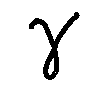

Each image in the data set has a shape of (105, 105)
The number of features in any image from the data set are 11025


In [5]:
# Display an example image
img = Image.open(r'/content/images_background/Greek/character03/0396_01.png')
display(img)

# Size and number of features
print("Each image in the data set has a shape of", img.size)
img_array = np.array(img)
flattened_img= img_array.flatten()
print("The number of features in any image from the data set are {0}".format(flattened_img.shape[0]))

In [6]:
# Generate class names 
base_class_name = 'character'
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

classes = gen_class_names(base_class_name) 

# One-hot encoding
def generate_one_hot_encoding(classes):
    """
       transforms the class labels to one-hot encoded labels 
    """
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

labels = generate_one_hot_encoding(classes)

In [7]:
# Function to plot all examples from a particular character of a language
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


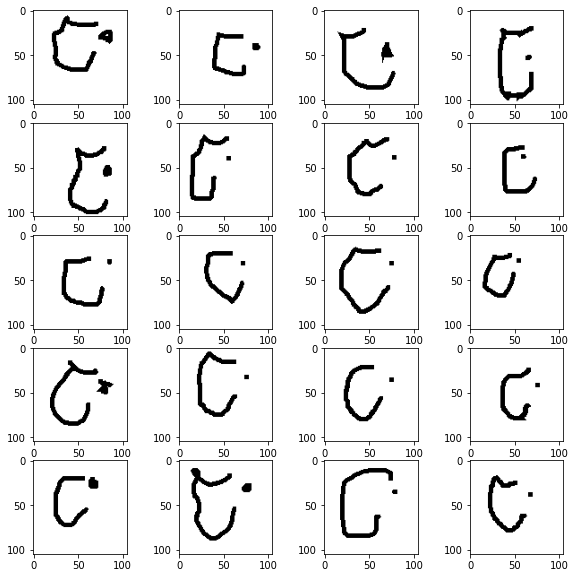

In [8]:
# Visualize omniglot data
data_path = '/content'
plot_images(os.path.join(data_path, 'images_background/Arcadian/character03/'))
print("Arcadian language, 20 samples of the third character.")

In [9]:
#This block preprocesses the images in the omniglot dataset and pickles them
#into an arrays that are easy to index by character type.
data_path = os.path.join('/content')
train_folder = '/content/images_background'
valpath = '/content/images_evaluation'

save_path = '/content' 
lang_dict = {}

def loadimgs(path,n=0):
    X = []
    y = []
    cat_dict = {} # initialize category dictionary
    lang_dict = {} # initialize 
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so we load these seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imageio.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict

X,y,c = loadimgs(train_folder)

with open(os.path.join(save_path,"train.pickle"), "wb") as f:
	pickle.dump((X,c),f)

X,y,c = loadimgs(valpath)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
	pickle.dump((X,c),f)

loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Cyrillic
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Bengali
loading alphabet: Grantha
loading alphabet: Tifinagh
loading alphabet: Armenian
loading alphabet: Balinese
loading alphabet: Japanese_(hiragana)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Latin
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: N_Ko
loading alphabet: Early_Aramaic
loading alphabet: Burmese_(Myanmar)
loading alphabet: Korean
loading alphabet: Gujarati
loading alphabet: Futurama
loading alphabet: Hebrew
loading alphabet: Arcadian
loading alphabet: Greek
loading alphabet: Tagalog
loading alphabet: Japanese_(katakana)
loading alphabet: Syriac_(Estrangelo)
loa

In [10]:
# Load and view training and validation alphabets. 
data_path = '/content'

with open(os.path.join(data_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n", list(classes.keys()))
print("\nValidation alphabets: \n", list(val_classes.keys()))
print("\nNumber of classes: \n", "For training = ", len(list(classes.keys())), "\n For validation = ", len(list(val_classes.keys())))


Training alphabets: 
 ['Anglo-Saxon_Futhorc', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Mkhedruli_(Georgian)', 'Asomtavruli_(Georgian)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Bengali', 'Grantha', 'Tifinagh', 'Armenian', 'Balinese', 'Japanese_(hiragana)', 'Malay_(Jawi_-_Arabic)', 'Latin', 'Braille', 'Sanskrit', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'N_Ko', 'Early_Aramaic', 'Burmese_(Myanmar)', 'Korean', 'Gujarati', 'Futurama', 'Hebrew', 'Arcadian', 'Greek', 'Tagalog', 'Japanese_(katakana)', 'Syriac_(Estrangelo)']

Validation alphabets: 
 ['ULOG', 'Ge_ez', 'Sylheti', 'Mongolian', 'Manipuri', 'Glagolitic', 'Malayalam', 'Atemayar_Qelisayer', 'Tengwar', 'Aurek-Besh', 'Angelic', 'Keble', 'Kannada', 'Oriya', 'Atlantean', 'Gurmukhi', 'Tibetan', 'Avesta', 'Syriac_(Serto)', 'Old_Church_Slavonic_(Cyrillic)']

Number of classes: 
 For training =  30 
 For validation =  20


### Model architecture


The Siamese network was proposed by Koch (2015). The network has two arms (right and left), each with a convolutional neural network (CNN) structure. The CNN architecture of each arm includes 9 convolutional layers aimed at feature selection. 

#### Weight initialization

Koch (2015) suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01, and the bias hyperparameter values with mean 0.5 and standard deviation 0.01. 

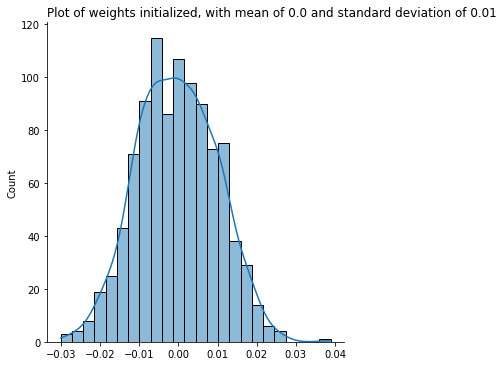

In [11]:
# Intialize layer weights with mean 0.0 and standard deviation 0.01
def initialize_weights(shape, name=None):
  return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

weights = initialize_weights((1000,1))
sns.displot(weights, kde = True, legend = False)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01", loc = "left")
plt.show()

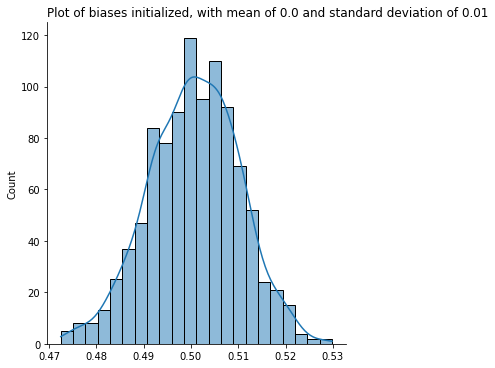

In [12]:
# Intialize bias with mean 0.5 and standard deviation of 0.01
def initialize_bias(shape, name=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

bias = initialize_bias((1000,1))
sns.displot(bias, kde = True, legend = False)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01", loc = "left")
plt.show()

#### Building the model

In [13]:
# Define the model 
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    # Left and right input arms 
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # CNN model 
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3)))
    
    # Model for each arm 
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Calculate distances between inputs using L1 distance
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Output layer
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    # Run entire model
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return siamese_net

In [14]:
# Get model
model = get_siamese_model((105, 105, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [15]:
# Compile model
optimizer = Adam(learning_rate = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Training the model

We define a class meant for loading batches to the data and 

In [16]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        # Randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)

        # Initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]

        # Initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)

            # Pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                # Add a random number to the category modulo n classes to ensure 2nd image has
                # different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """A generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else: # if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(data_path)

loading data from /content/train.pickle
loading data from /content/val.pickle


In [17]:
# Functions for plotting 

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

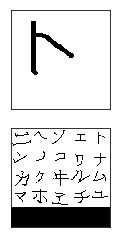

In [18]:
# Visualize the one-shot task which is being trained
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

In [19]:
# Define hyperparameters

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 5000
N_way = 20 # how many classes for testing one-shot tasks?
n_val = 250 # how many one-shot tasks to validate on?
best = -1
weights_path = '/content/data'
weights_path_2 = os.path.join(data_path, "model_weights.h5")
loss_history = [] #for plotting the training loss

Next, we start the training process. This code uses the functions defined in the Siamese_Loader class to train the model on the data. Hyperparameters, such batch size and number of iterations, are defined above. 

In [ ]:
print("Starting training process!")
print("-------------------------------------")
#t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    loss_history.append(loss)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        #print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        

model.load_weights(weights_path_2)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Got an average of 10.8% 20 way one-shot learning accuracy 


 ------------- 

Loss: 2.302931785583496

 ------------- 

Loss: 2.2954235076904297

 ------------- 

Loss: 2.2512028217315674

 ------------- 

Loss: 2.3094735145568848

 ------------- 

Loss: 2.278256893157959

 ------------- 

Loss: 2.273038625717163

 ------------- 

Loss: 2.2629542350769043

 ------------- 

Loss: 2.270503044128418

 ------------- 

Loss: 2.229839324951172

 ------------- 

Loss: 2.261411190032959
Evaluating model on 250 random 20 way one-shot learning tasks ... 

1/1 [==============================] - 0s 25ms/step
Got an average of 10.0% 20 way one-shot learning accuracy 

iteration 280, training loss: 2.26,

 ------------- 

Loss: 2.2871787548065186

 ------------- 

Loss: 2.220893621444702

 ------------- 

Loss: 2.30277419090271

 ------------- 

Loss: 2.2370219230651855

 ------------- 

Loss: 2.24

#### Visualizing Training Loss

In [ ]:
ite_range = np.arange(1,n_iter)


fig, ax = plt.subplots()

ax.plot(ite_range, loss_history)

ax.set_title("Training Loss")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")

plt.show()

### Testing the model 

In [ ]:
#load in the weights 
! git clone https://github.com/Limarma/DLiP.git

In [ ]:
weigths_dir = '/content/DLiP/weights/model_weights_1.h5'
model.load_weights(weigths_dir)

In [ ]:
# Accuracy functions

def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


In [ ]:
ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

#### Visualizing model accuracy 
The plots generated from the code below show the one-shot classification accuracy of the model, and the example which was tested. Accuracy is displayed as four different measurements:  


1.   Amount of correct classifications in the training set (yellow line).  
2.   Amount of correct classifications in the validation set (pink line).  
3.   Amount of times that the image with the next-closest distance (nearest-neighbor) was correctly classified (blue line).  
4.   Accuracy if guesing was random (green line).



In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)

## Interim Results: One-Shot Classification with Omniglot Data

# Part II


##2.1 Load Emojis 


In [ ]:
! git clone https://github.com/lucasrosenbusch/dl_project_data.git 

In [ ]:
#loop to resize to 105x 105 
import os
from PIL import Image

# Set the base directory for the folders
base_dir = '/content/dl_project_data/images_evaluation/emojis_1'

# Iterate through all the subdirectories within the base directory
for subdir, dirs, files in os.walk(base_dir):
    # Iterate through all the files in the current subdirectory
    for file in files:
        # Check if the file is a PNG image
        if file.endswith('.png'):
            # Construct the full path to the image file
            file_path = os.path.join(subdir, file)
            # Open the image file
            with Image.open(file_path) as img:
                # Resize the image to 105x105
                img = img.resize((105, 105))
                # Save the resized image
                img.save(file_path)

In [ ]:
#For loop to change the mode of the imgage from 105 x 105 x 1 to 105 x 105 x L

folder_path = '/content/dl_project_data/images_evaluation'
# Iterate over the folders dl_project_data


# Iterate over the alphabets
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    if not os.path.isdir(subfolder_path):
        continue

    # Iterate over the characters
    for subsubfolder_name in os.listdir(subfolder_path):
        subsubfolder_path = os.path.join(subfolder_path, subsubfolder_name)
        if not os.path.isdir(subsubfolder_path):
            continue

        # Iterate over the images in the subsubfolder
        for image_name in os.listdir(subsubfolder_path):
            image_path = os.path.join(subsubfolder_path, image_name)
            # Load the image
            print(image_path)
            im = Image.open(image_path)
            # Convert the image to grayscale
            im_gray = im.convert('L')

            # Save the grayscale image
            im_gray.save(image_path)


Did it resize the images correctly? 

In [ ]:
from PIL import Image
import numpy as np

emoji = Image.open(r'/content/dl_project_data/images_evaluation/emojis_1/character_05/smiling face holding back tears Kopie 6.png')
letter = Image.open(r'/content/dl_project_data/images_evaluation/Kannada/character01/1205_01.png')

# Get the width, height, and depth of the image
width, height = emoji.size
depth = emoji.mode
print("The dimensions of the emoji are {}x{}x{}".format(width, height, depth))

width, height = letter.size
depth = letter.mode

# Print the dimensions
print("The dimensions of the letter are {}x{}x{}".format(width, height, depth))


We need a new function of load the images to avoid the shape bug. Alternatively, we can remove this blog if we adjust delete the image from the folder. I think it was one of the heart eye emojies but not sure anymore 

##2.2 Data Augmentation
While data augemntation is usualy done online and in order to gernerate training images, we augment data offline. To be comparable to the evualation of letters, we generate 20 examples of each emoji

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator

# Set the base directory for the folders
base_dir = '/content/dl_project_data/emoji_evaluation'

# Set the image data generator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterate through all the subdirectories within the base directory
for subdir, dirs, files in os.walk(base_dir):
    # Iterate through all the files in the current subdirectory
    for file in files:
        # Check if the file is a PNG image
        if file.endswith('.png'):
            # Construct the full path to the image file
            file_path = os.path.join(subdir, file)
            # Load the image
            img = tf.keras.utils.load_img(file_path, color_mode='grayscale')
            # Convert the image to a NumPy array
            img_array = tf.keras.utils.img_to_array(img)
            # Reshape the image to a single sample with 1 channel
            img_array = img_array.reshape((1, ) + img_array.shape)
            # Generate batches of augmented images
            i = 0
            for batch in datagen.flow(img_array, save_to_dir=subdir, save_prefix='augmented', save_format='png'):
                i += 1
                # Generate only a single augmented image
                if i > 1:
                    break

In [ ]:
plot_images('/content/dl_project_data/emoji_evaluation/emojis/character_01')
print("20 augemtations of the diamond.")

##2.3 Pickle the evaluation dataset for later use 

In [ ]:
import sys
import numpy as np
import imageio
import pickle
import os

"""Script to preprocess the omniglot dataset and pickle it into an array that's easy
    to index by character type"""


lang_dict = {}


def loadimgs(path,n=0):
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    #we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        #every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imageio.imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images[:20]))# [:20]this is the crucial line that removes the shape bug
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

This code block writes emojy into new directory without tha alphabet images

In [ ]:
# this codeblock makes a new directory because the dlip_evaluation folder also contains all images that we do not want to evaluate
import shutil
import os
 
# path to source directory
src_dir = '/content/dl_project_data/images_evaluation/emojis_1'
 
# path to destination directory
dest_dir = '/content/dl_project_data/emoji_evaluation/emojis'
 
# getting all the files in the source directory
files = os.listdir(src_dir)
 
shutil.copytree(src_dir, dest_dir)

In [ ]:
#make pickles 
train_folder = '/content/dl_project_data/images_background'
val_folder = '/content/dl_project_data/emoji_evaluation/'
save_path = '/content/dl_project_data'


X,y,c=loadimgs(train_folder)
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
	pickle.dump((X,c),f)

X,y,c=loadimgs(val_folder)
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
	pickle.dump((X,c),f)

## load model 

In [ ]:
model = get_siamese_model((105, 105, 1))

In [ ]:
# load weigths 
weigths_dir = '/content/model_weights_1.h5'
model.load_weights(weigths_dir)

##Test the model on the emoji images 

In [ ]:
class Emoji_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def make_oneshot_task(self,N,s="val",language = None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        N = 19
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))

In [ ]:
data_path = os.path.join('/content/dl_project_data')
loader = Emoji_Loader(data_path)

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 5
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()
